In [1]:
# Importing dependencies

import numpy as np
# np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,  verbose=0, mode='min')
callbacks_list = [earlystop]

<Axes: >

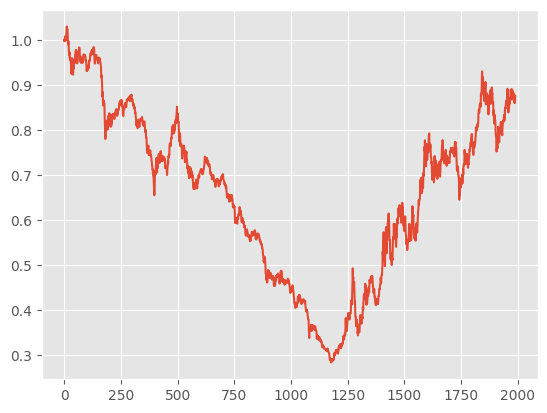

In [3]:
url = 'new2.csv'
df = pd.read_csv(url)
df['close_price'].plot()

In [4]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(1,input_shape = (X_train.shape[1],1),return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val),
                        verbose = 1, shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [5]:
# Evaluating the model
def evaluate_model(model,test,timesteps, sc):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test, verbose=0)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    Y_hat = np.array(Y_hat)
    Y_hat = sc.inverse_transform(Y_hat)
    Y_test = sc.inverse_transform(Y_test)
    print(Y_hat.shape, Y_test.shape)
    df2 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_hat.flatten()})
    df2['actual_return'] = df2['Actual'].pct_change()
    # column predicted_return is (predicted - actual.shift(1))/actual.shift(1)
    df2['predicted_return'] = df2['Predicted'].pct_change()
    # column signal is 1 if predicted_return > 0 and actual_return > 0 or predicted_return < 0 and actual_return < 0
    df2['signal'] = np.where((df2['predicted_return'] > 0) & (df2['actual_return'] > 0) | (df2['predicted_return'] < 0) & (df2['actual_return'] < 0), 1, 0)
    # accuracy is the mean of the signal column
    accuracy = df2['signal'].mean()
    # construct a strategy, if predicted_return > 0, then I plus (actual.shift(-1) - actual), otherwise I minus (actual.shift(-1) - actual)
    df2['strategy'] = np.where(df2['predicted_return'] > 0, (df2['Actual'].shift(-1) - df2['Actual']), -(df2['Actual'].shift(-1) - df2['Actual']))
    # cumulative_strategy is the cumsum of column strategy
    cumulative_strategy = df2['strategy'].sum()
    return mse, rmse, r2, Y_test, Y_hat, accuracy, cumulative_strategy


In [6]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [7]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

(1989,)


<Axes: >

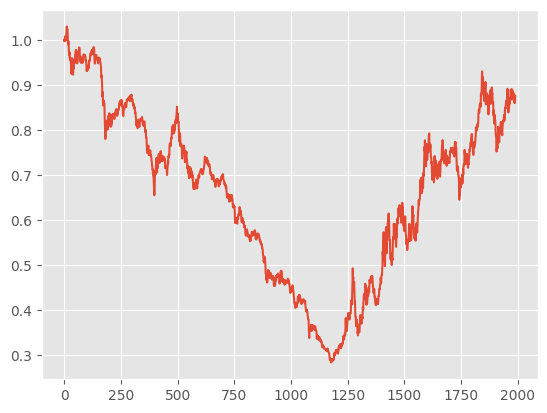

In [8]:
# Extracting the series
series = df['close_price']
print(series.shape)
series.plot()

In [9]:
series2 = series.values.reshape(-1,1)
train_data = series2[:int(0.3*len(series))]
val_data = series2[int(0.3*len(series)):int(0.4*len(series))]
test_data = series2[int(0.4*len(series)):int(0.5*len(series))]

print(train_data.shape,val_data.shape,test_data.shape)

(596, 1) (199, 1) (199, 1)


In [10]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
all_data = sc.transform(series2)
print(train.shape,val.shape,test.shape)

(596, 1) (199, 1) (199, 1)


In [11]:
timesteps = 40
hl = [40,35]
lr = 0.001
batch_size = 64
num_epochs = 200

Epoch 1/200


/Users/ldvyyc/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4374.6797 - val_loss: 0.0115
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 645.8447 - val_loss: 0.0114
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 142.7433 - val_loss: 0.0115
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 107.0338 - val_loss: 0.0116
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 81.0271 - val_loss: 0.0117
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 52.5428 - val_loss: 0.0119
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13.5516 - val_loss: 0.0122
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 113.2298 - val_loss: 0.0122
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9576 - val_loss: 0.0125
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9554 - val_loss: 0.0139
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3641 - val_loss: 0.0195
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2926 - val_

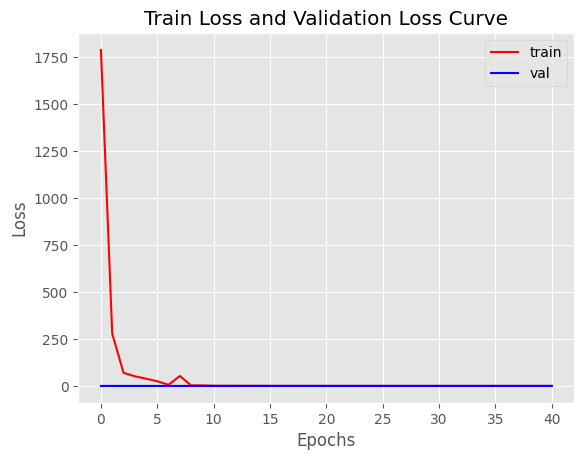

In [12]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

(159, 1) (159, 1)
RMSE = 0.49243645824575605
MSE = 0.24249366540962425
R-Squared Score = -20.33682637362735
Accuracy = 0.0
Cumulative Strategy = 0.11408370097754467


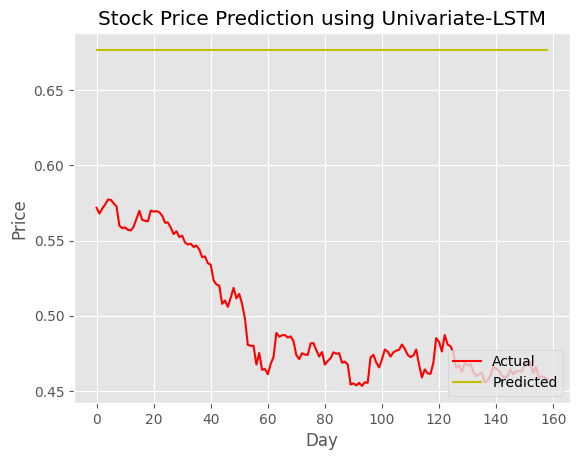

In [13]:
mse, rmse, r2_value,true,predicted, accuracy, cumu = evaluate_model(model,test,timesteps, sc)
print('RMSE = {}'.format(rmse))
print('MSE = {}'.format(rmse*rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Accuracy = {}'.format(accuracy))
print('Cumulative Strategy = {}'.format(cumu))
plot_data(true,predicted)

In [14]:
def generate_output(model, all_data, timesteps, sc):
    X_all = []
    Y_all = []
    for i in range(timesteps,all_data.shape[0]):
        X_all.append(all_data[i-timesteps:i])
        Y_all.append(all_data[i])
    X_all,Y_all = np.array(X_all),np.array(Y_all)
    Y_hat = model.predict(X_all)
    Y_hat = np.array(Y_hat)
    Y_hat = sc.inverse_transform(Y_hat)
    Y_all = sc.inverse_transform(Y_all)
    return Y_all, Y_hat

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


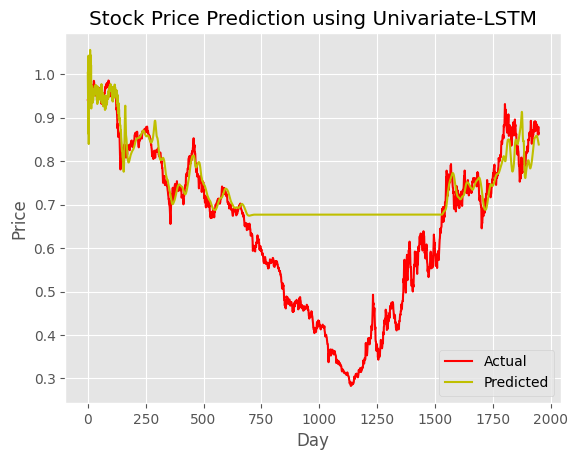

In [15]:
Y_all, Y_hat = generate_output(model, all_data,timesteps, sc)
plot_data(Y_all,Y_hat)

In [16]:
# combine Y_all and Y_hat into one dataframe
df2 = pd.DataFrame({'Actual': Y_all.flatten(), 'Predicted': Y_hat.flatten()})
df2

,Actual,Predicted
0,0.939790,1.002807
1,0.937604,0.947339
2,0.940188,0.863392
3,0.949928,1.042373
4,0.956885,0.839193
...,...,...
1944,0.861505,0.849830
1945,0.864539,0.847072
1946,0.865939,0.843582
1947,0.861039,0.840278


In [17]:
df

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2
0,0.003664,-0.000610,0.002033,-0.006302,-0.001220,0.005386,-0.002458,0.002366,0.000687,0.004660,0.998780,1.000000,1.000000,1.000000,1.002440
1,-0.002636,0.001425,0.005699,-0.000407,0.003664,0.005449,-0.002048,0.002625,0.000834,0.003755,1.002440,1.004472,0.998374,1.000203,0.999797
2,0.006507,-0.002028,0.000000,-0.003448,-0.002636,0.004379,-0.002323,0.001592,0.000272,0.004126,0.999797,1.002440,0.998984,1.000407,1.006302
3,0.003030,-0.003457,0.007727,-0.004270,0.006507,0.005027,-0.002700,0.002543,-0.000449,0.003808,1.006302,1.007522,0.995528,0.996341,1.009351
4,0.000403,0.001818,0.005253,0.000000,0.003030,0.005070,-0.002183,0.002636,-0.000015,0.003320,1.009351,1.011588,1.006302,1.008132,1.009758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539
1985,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939
1986,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039
1987,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906


In [18]:
# drop first 50 rows from df
df3 = df[timesteps:]
df3

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2
40,-0.002327,0.001721,0.018933,0.000430,0.017212,0.008032,-0.008138,-0.000358,-0.000682,0.014228,0.939790,0.941381,0.924286,0.925479,0.937604
41,0.002756,0.001692,0.006768,-0.009306,-0.002327,0.007802,-0.008351,-0.000716,-0.000250,0.012712,0.937604,0.946151,0.931045,0.941381,0.940188
42,0.010359,0.001696,0.005512,-0.002544,0.002756,0.007386,-0.007295,-0.000085,0.000104,0.012554,0.940188,0.942772,0.935219,0.939194,0.949928
43,0.007324,0.004228,0.013954,0.002960,0.010359,0.008580,-0.005430,0.001814,0.000854,0.011873,0.949928,0.953307,0.942971,0.944163,0.956885
44,-0.004155,0.000628,0.009416,-0.002929,0.007324,0.008732,-0.004976,0.002816,0.000812,0.011785,0.956885,0.958872,0.947145,0.950524,0.952909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539
1985,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939
1986,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039
1987,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906


In [19]:
df3.reset_index(drop=True, inplace=True)

In [20]:
# concat df3 and df2
df4 = pd.concat([df3, df2], axis=1)
df4

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2,Actual,Predicted
0,-0.002327,0.001721,0.018933,0.000430,0.017212,0.008032,-0.008138,-0.000358,-0.000682,0.014228,0.939790,0.941381,0.924286,0.925479,0.937604,0.939790,1.002807
1,0.002756,0.001692,0.006768,-0.009306,-0.002327,0.007802,-0.008351,-0.000716,-0.000250,0.012712,0.937604,0.946151,0.931045,0.941381,0.940188,0.937604,0.947339
2,0.010359,0.001696,0.005512,-0.002544,0.002756,0.007386,-0.007295,-0.000085,0.000104,0.012554,0.940188,0.942772,0.935219,0.939194,0.949928,0.940188,0.863392
3,0.007324,0.004228,0.013954,0.002960,0.010359,0.008580,-0.005430,0.001814,0.000854,0.011873,0.949928,0.953307,0.942971,0.944163,0.956885,0.949928,1.042373
4,-0.004155,0.000628,0.009416,-0.002929,0.007324,0.008732,-0.004976,0.002816,0.000812,0.011785,0.956885,0.958872,0.947145,0.950524,0.952909,0.956885,0.839193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539,0.861505,0.849830
1945,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939,0.864539,0.847072
1946,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039,0.865939,0.843582
1947,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906,0.861039,0.840278


In [21]:
df4['predicted_return'] = df4['Predicted'].pct_change()
df4

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2,Actual,Predicted,predicted_return
0,-0.002327,0.001721,0.018933,0.000430,0.017212,0.008032,-0.008138,-0.000358,-0.000682,0.014228,0.939790,0.941381,0.924286,0.925479,0.937604,0.939790,1.002807,NaN
1,0.002756,0.001692,0.006768,-0.009306,-0.002327,0.007802,-0.008351,-0.000716,-0.000250,0.012712,0.937604,0.946151,0.931045,0.941381,0.940188,0.937604,0.947339,-0.055313
2,0.010359,0.001696,0.005512,-0.002544,0.002756,0.007386,-0.007295,-0.000085,0.000104,0.012554,0.940188,0.942772,0.935219,0.939194,0.949928,0.940188,0.863392,-0.088614
3,0.007324,0.004228,0.013954,0.002960,0.010359,0.008580,-0.005430,0.001814,0.000854,0.011873,0.949928,0.953307,0.942971,0.944163,0.956885,0.949928,1.042373,0.207300
4,-0.004155,0.000628,0.009416,-0.002929,0.007324,0.008732,-0.004976,0.002816,0.000812,0.011785,0.956885,0.958872,0.947145,0.950524,0.952909,0.956885,0.839193,-0.194921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539,0.861505,0.849830,-0.002659
1945,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939,0.864539,0.847072,-0.003246
1946,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039,0.865939,0.843582,-0.004120
1947,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906,0.861039,0.840278,-0.003917


In [22]:
# drop first row
df5 = df4[1:]
df5

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2,Actual,Predicted,predicted_return
1,0.002756,0.001692,0.006768,-0.009306,-0.002327,0.007802,-0.008351,-0.000716,-0.000250,0.012712,0.937604,0.946151,0.931045,0.941381,0.940188,0.937604,0.947339,-0.055313
2,0.010359,0.001696,0.005512,-0.002544,0.002756,0.007386,-0.007295,-0.000085,0.000104,0.012554,0.940188,0.942772,0.935219,0.939194,0.949928,0.940188,0.863392,-0.088614
3,0.007324,0.004228,0.013954,0.002960,0.010359,0.008580,-0.005430,0.001814,0.000854,0.011873,0.949928,0.953307,0.942971,0.944163,0.956885,0.949928,1.042373,0.207300
4,-0.004155,0.000628,0.009416,-0.002929,0.007324,0.008732,-0.004976,0.002816,0.000812,0.011785,0.956885,0.958872,0.947145,0.950524,0.952909,0.956885,0.839193,-0.194921
5,0.000000,0.002700,0.003947,-0.008101,-0.004155,0.007862,-0.005544,0.001549,0.001156,0.011167,0.952909,0.960661,0.949133,0.959469,0.952909,0.952909,1.034986,0.233311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539,0.861505,0.849830,-0.002659
1945,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939,0.864539,0.847072,-0.003246
1946,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039,0.865939,0.843582,-0.004120
1947,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906,0.861039,0.840278,-0.003917


In [23]:
# calculate accuracy, if predicted_return and label have same sign then 1 else 0
df5['accuracy'] = np.where(np.sign(df5['predicted_return']) == np.sign(df5['label']), 1, 0)
# sum accuracy and divide by total number of rows
accuracy = df5['accuracy'].sum()/df5['accuracy'].count()

/var/folders/bw/b76wldrx3mz1kk0lzd4cfrmc0000gn/T/ipykernel_64790/479852568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['accuracy'] = np.where(np.sign(df5['predicted_return']) == np.sign(df5['label']), 1, 0)


In [24]:
accuracy

0.2972279260780287

# Cross Validation

In [25]:
# Hyperparameters
timesteps = 40
hl = [40,35]
lr = 0.0005
batch_size = 64
num_epochs = 200

In [26]:
slice_size = 200

In [27]:
# mse_all = []
# rmse_all = []
# r2_all = []
# accuracy_all = []
# cumu_all = []
# for i in range(3, 8):
#     train_data = series2[:int(i*slice_size)]
#     val_data = series2[int(i*slice_size):int((i+1)*slice_size)]
#     test_data = series2[int((i+1)*slice_size):int((i+2)*slice_size)]
#     sc = MinMaxScaler()
#     train = sc.fit_transform(train_data)
#     val = sc.transform(val_data)
#     test = sc.transform(test_data)
#     model_cross,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
#     mse, rmse, r2_value,true,predicted, accuracy, cumu = evaluate_model(model_cross,test,timesteps, sc)
#     mse_all.append(mse)
#     rmse_all.append(rmse)
#     r2_all.append(r2_value)
#     accuracy_all.append(accuracy)
#     cumu_all.append(cumu)
#     del model_cross

In [28]:
average_mse = sum(mse_all)/len(mse_all)
average_rmse = sum(rmse_all)/len(rmse_all)
average_r2 = sum(r2_all)/len(r2_all)
average_accuracy = sum(accuracy_all)/len(accuracy_all)
average_cumu = sum(cumu_all)/len(cumu_all)
print('Average RMSE = {}'.format(average_rmse))
print('Average MSE = {}'.format(average_rmse*average_rmse))
print('Average R-Squared Score = {}'.format(average_r2))
print('Average Accuracy = {}'.format(average_accuracy))
print('Average Cumulative Strategy = {}'.format(average_cumu))

NameError: name 'mse_all' is not defined

In [ ]:
print(cumu_all)

[0.07621364393791802, -0.1112210689794218, -0.0545044825322904, 0.070218697212998]
